**SETTING THE ENVIRONMENT**

In [35]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import esda

import pandas as pd
import geopandas as gpd
import libpysal as lps
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
import mapclassify as mc

%matplotlib inline

In [36]:
# Converting from data frame into geo data frame
spatio_temporal_data = pd.read_csv('all spatial data.csv')
spatio_temporal_data_loc = gpd.GeoDataFrame(spatio_temporal_data, geometry = gpd.points_from_xy(spatio_temporal_data.longit, spatio_temporal_data.latit))

spatio_temporal_data_loc.head(3)

,block,longit,latit,geom,birds,nat_cover,built_cover,observer_intensity,ave_precip,roadlength,p_roadlength,g_roadlength,surr_pop,abs_pop,ave_temper,geometry
0,1,9.0,390.0,0103000020407100000100000005000000000000000094...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.000 390.000)
1,2,10.0,388.0,0103000020407100000100000005000000000000000088...,0,1000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.000 388.000)
2,3,10.0,389.0,0103000020407100000100000005000000000000000088...,0,1000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.000 389.000)


**MAPPING OBSERVER INTENSITY**

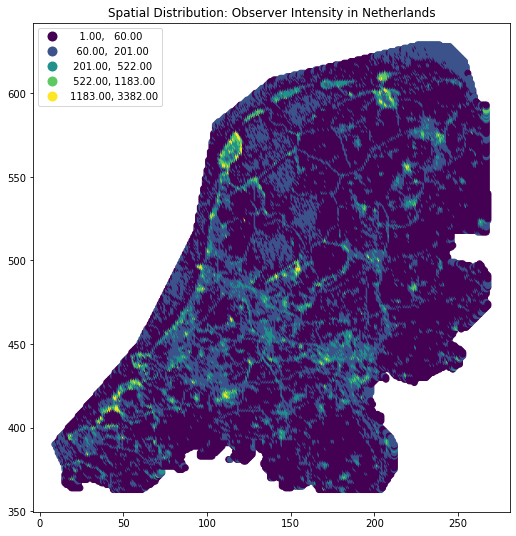

In [37]:
# Straight forward visualization of observer intensity value
spatio_temporal_data_loc['observer_intensity'].fillna((spatio_temporal_data_loc['observer_intensity'].mean()), inplace = True)

spatio_temporal_data_loc.plot(column = 'observer_intensity',
                              legend = bool,
                              scheme = 'NaturalBreaks',
                              figsize = (9,9))

plt.title("Spatial Distribution: Observer Intensity in Netherlands")
plt.savefig('observer intensity distribution.png')

**MAPPING THE SPATIAL LAG OF OBSERVER INTENSITY (SPATIAL AUTO CORRELATION)**

In [38]:
# Setting the spatial weight, indicating geographical similarility between neighboring blocks
wq = lps.weights.Queen.from_dataframe(spatio_temporal_data_loc)
wq.transform = 'r'

oi = observer_intensity = spatio_temporal_data_loc['observer_intensity']
lag_observer_intensity = lps.weights.lag_spatial(wq, oi)

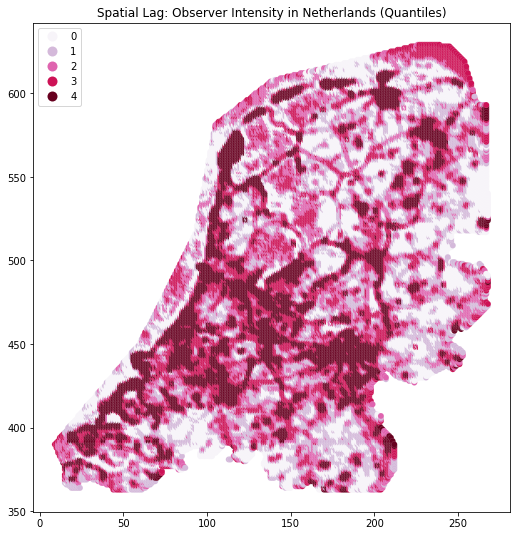

In [39]:
# Visualizing the spatial lag
oisl = observer_intensity_spatial_lag = mc.Quantiles(lag_observer_intensity, k = 5)

f, ax = plt.subplots(1, figsize = (9, 9))

spatio_temporal_data_loc.assign(cl = oisl.yb).plot(column = 'cl',
                               categorical = True,
                               k = 5,
                               cmap = 'PuRd',
                               linewidth = 0.1,
                               ax = ax,
                               edgecolor = 'white', 
                               legend = True)

plt.title("Spatial Lag: Observer Intensity in Netherlands (Quantiles)")
plt.savefig('observer intensity spatial lag.png')
plt.show()

**MAPPING THE BINARY CLASSIFICATION OF OBSERVER INTENSITY (SPATIAL DICHOTOMY)**

In [40]:
# Defining the binary value
oi_upper = oi > oi.median()
labels = ["0 Low", "1 High"]
oi_upper = [labels[i] for i in 1 * oi_upper]
spatio_temporal_data_loc['oi_upper'] = oi_upper

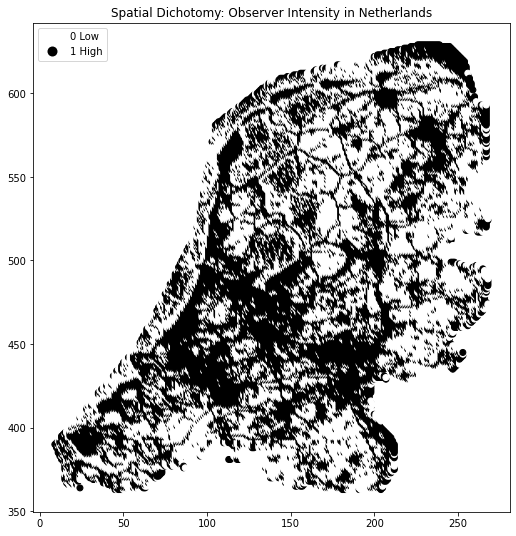

In [41]:
# Visualizing binary map
fig, ax = plt.subplots(figsize = (9,9), 
                       subplot_kw = {'aspect':'equal'})

spatio_temporal_data_loc.plot(column = 'oi_upper',
        cmap = 'binary',
        legend = True,
        ax = ax)

plt.title("Spatial Dichotomy: Observer Intensity in Netherlands")
plt.savefig('observer intensity spatial dichotomy.png')

**THREE CLASS CLUSTERING WITH K-MEANS**

/tmp/ipykernel_3522/3843080800.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_spatio_temporal_data_loc = spatio_temporal_data_loc.fillna(spatio_temporal_data_loc.mean())


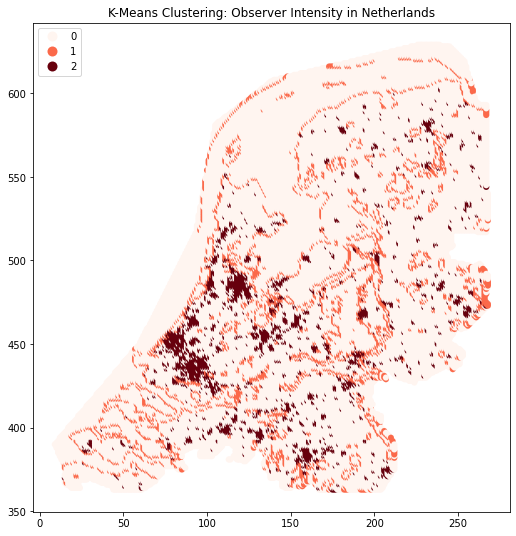

In [45]:
# Changing null valus into mean values (k-means can not works with missing values)
mean_spatio_temporal_data_loc = spatio_temporal_data_loc.fillna(spatio_temporal_data_loc.mean())

# Choosing variables for clustering
km3 = cluster.KMeans(n_clusters = 3)
km3_cls = km3.fit(mean_spatio_temporal_data_loc[['birds',
                                            'nat_cover',
                                            'built_cover',
                                            'roadlength',
                                            'p_roadlength',
                                            'g_roadlength',
                                            'surr_pop',
                                            'abs_pop',
                                            'ave_temper',
                                            'ave_precip',
                                            'observer_intensity']].values)

# Visuzalizing the cluster
f, ax = plt.subplots(1, figsize = (9, 9))
mean_spatio_temporal_data_loc.assign(cl = km3_cls.labels_).plot(column = 'cl',
                                     categorical = True,
                                     legend = True,
                                     cmap = 'Reds',
                                     linewidth = 0.1,
                                     ax = ax)

plt.title("K-Means Clustering: Observer Intensity in Netherlands")
plt.savefig('observer intensity k-means cluster.png')
plt.show()